In [1]:
#imports

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pathlib
import gc

In [2]:
class_names = ['NonDemented', 'Demented']
num_classes = len(class_names)
batch_size = 32
input_shape = (176, 208, 3)

def process(image, label):
    image /= 255.
    label = tf.one_hot(label, num_classes)
    return image, label

def flip(image, label):
    x = tf.image.random_flip_left_right(image)
    images = [image, x]
    labels = [label, label]
    return images, labels

def augment(image, label):
    func = tf.numpy_function(flip, [image, label], [tf.float32, tf.float32])
    return func

Found 5121 files belonging to 2 classes.
Found 1279 files belonging to 2 classes.
(32, 176, 208, 3)
(32, 2)


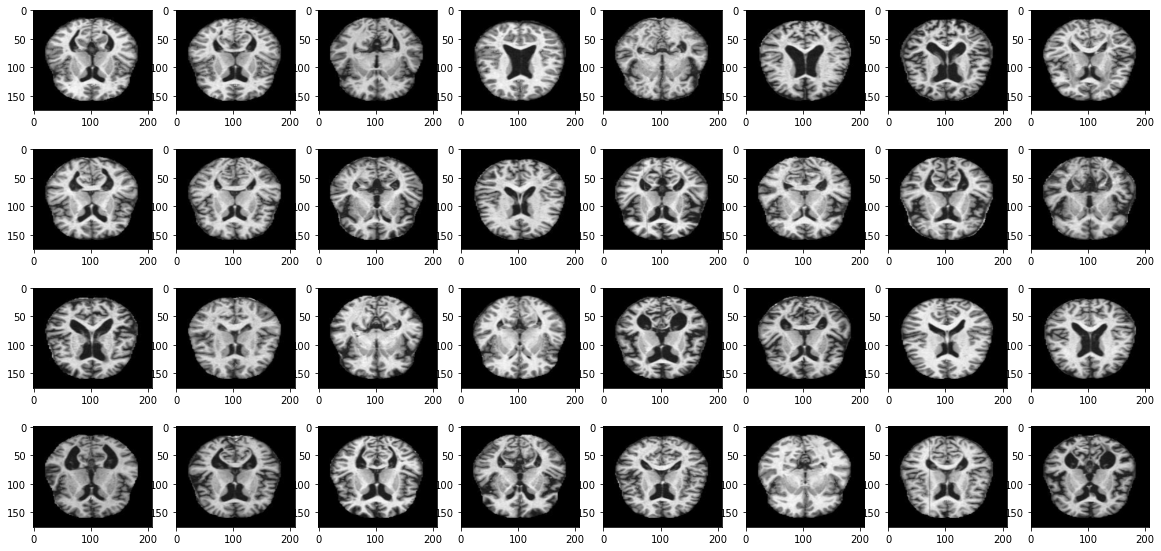

tf.Tensor(-2, shape=(), dtype=int64)
320 batches, 10240 images


In [248]:
train_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/train')
test_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/test')

train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        class_names=class_names,
        batch_size=batch_size,
        image_size=input_shape[0:2])

test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        class_names=class_names,
        batch_size=batch_size,
        image_size=input_shape[0:2])

train_dataset = train_dataset.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE).unbatch().unbatch()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)

fig = plt.figure(figsize=(20,20))

batch_count = 0
image_count = 0
for images, labels in train_dataset:
    if batch_count == 0:
        print(np.shape(images))
        print(np.shape(labels))
        for i in range(np.shape(labels)[0]):
            image = images[i]
            fig.add_subplot(8,8,i+1)
            plt.imshow(image)
    batch_count += 1
    image_count += np.shape(labels)[0]
   
plt.show()

#image_count = 0
#for image, label in train_dataset:
#    if image_count < 32:
#        fig.add_subplot(8,8,image_count+1)
#        plt.imshow(image)
#    image_count += 1
   
#plt.show()

print(tf.data.experimental.cardinality(train_dataset))
#print(f"{image_count} images")
print(f"{batch_count} batches, {image_count} images")

In [94]:
######################## deprecated ########################

train_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/train')
test_dir = pathlib.Path('../Project/Alzheimer_s Dataset_binary/test')

datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                       #rotation_range=10,
                                                       rescale=1./255
                                                       #brightness_range=(0.8,1.1),
                                                       #zoom_range=0.2,
                                                       #width_shift_range=0.1,
                                                       #height_shift_range=0.1
                                                      )

simple_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_dir,
        classes=class_names,
        class_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        target_size=input_shape[0:2])

test_generator = simple_datagen.flow_from_directory(
        test_dir,
        classes=class_names,
        class_mode='categorical',
        shuffle=True,
        batch_size=batch_size,
        target_size=input_shape[0:2])

Found 5121 images belonging to 2 classes.
Found 1279 images belonging to 2 classes.


In [249]:
vgg = keras.applications.VGG19(
        include_top=False,
        input_shape=input_shape,
        pooling=max)

for layer in vgg.layers:
    layer.trainable = False
#vgg.layers[17].trainable = True
#vgg.layers[18].trainable = True
#vgg.layers[19].trainable = True
#vgg.layers[20].trainable = True

vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [211]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [251]:
#### Create a transfer learning model ####

epochs = 30
keras.backend.clear_session()
gc.collect()
model = keras.models.Sequential([
        keras.Input(input_shape),
        layers.GaussianNoise(0.1),
        vgg,
        layers.Flatten(),
        layers.Dropout(0.6),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax'),
    
    ])

model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
history = model.fit(train_dataset,
                    #steps_per_epoch=image_count // batch_size,
                    batch_size=batch_size,
                    #callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                    epochs=epochs,
                    validation_data=test_dataset
                    #validation_steps=800 // batch_size
                   )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 176, 208, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 5, 6, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dropout (Dropout)            (None, 15360)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15360)             61440     
_________________________________________________________________
dense (Dense)                (None, 512)               7864832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

ValueError: in user code:

    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:792 train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:436 update_state
        self.build(y_pred, y_true)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:358 build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:1376 map_structure_up_to
        return map_structure_with_tuple_paths_up_to(
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:1474 map_structure_with_tuple_paths_up_to
        results = [
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:1475 <listcomp>
        func(*args, **kwargs) for args in zip(flat_path_gen, *flat_value_gen)
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\nest.py:1378 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:482 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:482 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py:503 _get_metric_object
        y_t_rank = len(y_t.shape.as_list())
    C:\Users\dongh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\tensor_shape.py:1217 as_list
        raise ValueError("as_list() is not defined on an unknown TensorShape.")

    ValueError: as_list() is not defined on an unknown TensorShape.


In [18]:
#### Create a CNN from scratch ####

epochs = 30
keras.backend.clear_session()
gc.collect()
model = keras.models.Sequential([
        keras.Input(input_shape),
        #layers.GaussianNoise(0.5),
        #Creates the convolutional layer
        layers.BatchNormalization(),
        layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
        layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(),
        
        layers.SeparableConv2D(32, kernel_size=(3,3), activation='relu'),
        layers.SeparableConv2D(32, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(),
        
        layers.SeparableConv2D(64, kernel_size=(3,3), activation='relu'),
        layers.SeparableConv2D(64, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(),
        
        layers.SeparableConv2D(128, kernel_size=(3,3), activation='relu'),
        layers.SeparableConv2D(128, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(),
        
        layers.SeparableConv2D(256, kernel_size=(3,3), activation='relu'),
        layers.SeparableConv2D(256, kernel_size=(3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(),
    
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax'),
    ])
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'])
history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=test_generator)

Epoch 1/30
161/161 [==============================] - 42s 252ms/step - loss: 0.7203 - auc: 0.6604 - accuracy: 0.6180 - val_loss: 0.6941 - val_auc: 0.5004 - val_accuracy: 0.5004
Epoch 2/30
161/161 [==============================] - 40s 247ms/step - loss: 0.6167 - auc: 0.7280 - accuracy: 0.6663 - val_loss: 0.7139 - val_auc: 0.4996 - val_accuracy: 0.4996
Epoch 3/30
161/161 [==============================] - 40s 249ms/step - loss: 0.6028 - auc: 0.7373 - accuracy: 0.6766 - val_loss: 0.7158 - val_auc: 0.5531 - val_accuracy: 0.5004
Epoch 4/30
161/161 [==============================] - 41s 253ms/step - loss: 0.5966 - auc: 0.7448 - accuracy: 0.6782 - val_loss: 1.3528 - val_auc: 0.5991 - val_accuracy: 0.5004
Epoch 5/30
161/161 [==============================] - 41s 252ms/step - loss: 0.5974 - auc: 0.7443 - accuracy: 0.6848 - val_loss: 1.0139 - val_auc: 0.6049 - val_accuracy: 0.5004
Epoch 6/30
 76/161 [=============>................] - ETA: 20s - loss: 0.5923 - auc: 0.7500 - accuracy: 0.6920

KeyboardInterrupt: 

In [ ]:
plt.title('VGG19 Transfer Learning w/ Gaussian(1) Accuracy with Dropout')

plt.plot(history.history['accuracy'], label = "training acc.")
plt.plot(history.history['val_accuracy'], label = "validation acc.")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc.', 'validation acc.'], loc='upper left')

plt.savefig("../Project/Result2/VGG19_MODEL_Pre_1_ACCURACY_adam_dropout.png")
plt.show()
